## Web Scraping

In [5]:
from bs4 import BeautifulSoup
import requests
import time
import pandas as pd

In [2]:
# Function to scrape the pages on the trust pilot site for the text of the review and the star rating
# This Function starts on the second page of reviews and can go up to any number of pages
def scrape_review_pages(page_start, page_end):
    headers = {'user-agent': "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36"}
    reviews = []
    for i in range(page_start, page_end):
        url = 'https://www.trustpilot.com/review/hellofresh.com?page=' + str(i)
        try:
            html_page = requests.get(url, headers = headers)
            #print(url)
            html_page.raise_for_status()
            soup = BeautifulSoup(html_page.content, 'html.parser')
            review_elements = soup.find_all("article", class_="styles_reviewCard__hcAvl")
            for review_element in review_elements:
                review_text = review_element.find("p", class_="typography_body-l__KUYFJ")
                #print(review_text)
                if review_text is not None:
                    review_text = review_text.text.strip()
                else:
                    review_text = "No review text available."
                review_score_tag = review_element.find("div", class_="star-rating_starRating__4rrcf")
                if review_score_tag is not None:
                    review_score = int(review_score_tag.img['alt'].split()[1])
                else:
                    review_score = 0
                #print(review_score)
                review_object = {"text": review_text, "score": review_score}
                reviews.append(review_object)
            time.sleep(3)
        except requests.exceptions.RequestException as e:
            print(f"Error fetching page {i}: {e}")
            continue
    return reviews

**Time to scrape**

In [3]:
# Have to scrape the website in batches so it does not crash
# This will take a while
Hello_fresh_reviews = scrape_review_pages(2,275)
hf2 = scrape_review_pages(275,447)
hf3 = scrape_review_pages(447, 597)
hf4 = scrape_review_pages(597, 747)
hf5 = scrape_review_pages(747,900)
hf6 = scrape_review_pages(900,1100)
hf7 = scrape_review_pages(1100,1275)
hf8 = scrape_review_pages(1275,1475)
hf9 = scrape_review_pages(1475,1675)
hf10 = scrape_review_pages(1675,1875)
hf11 = scrape_review_pages(1875,2075)
hf12 = scrape_review_pages(2075,2200)
hf13 = scrape_review_pages(2200,2346)

In [6]:
# Saving each batch as a DataFrame
df = pd.DataFrame(Hello_fresh_reviews)
df2 = pd.DataFrame(hf2)
df3 = pd.DataFrame(hf3)
df4 = pd.DataFrame(hf4)
df5 = pd.DataFrame(hf5)
df6 = pd.DataFrame(hf6)
df7 = pd.DataFrame(hf7)
df8 = pd.DataFrame(hf8)
df9 = pd.DataFrame(hf9)
df10 = pd.DataFrame(hf10)
df11 = pd.DataFrame(hf11)
df12 = pd.DataFrame(hf12)
df13 = pd.DataFrame(hf13)

In [7]:
# Concatenating all the DataFrames
fresh_df = pd.concat([df, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13], 0)

In [10]:
# Resetting the index so that it is continuos
hello_fresh_df = fresh_df.reset_index(drop = True)

In [11]:
# Dropping all of the rows that have "No review text available."
hello_fresh_df = hello_fresh_df.drop(hello_fresh_df[hello_fresh_df['text'] == "No review text available."].index)

In [12]:
# Resetting the index again
hello_fresh_df = hello_fresh_df.reset_index(drop=True)

In [13]:
# Changing the numeric star rating to positive/neutral/negative sentiments
changing_numeric_tosentiment = {1: "negative", 
                                2: "negative", 
                                3: "neutral", 
                                4: "positive", 
                                5: "positive" }
hello_fresh_df['score'] = hello_fresh_df['score'].replace(changing_numeric_tosentiment)

In [16]:
# Saving the dataframe to a csv
hello_fresh_df.to_csv("hello_fresh_reviews.csv")

**Important to save as a csv so you do not have to go through scraping process again!**

## Topic Modeling - Unsupervised Learning

In [17]:
# Importing packages need for topic modeling (Pandas has already been uploaded)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re  
import nltk 
from nltk.tokenize import word_tokenize
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk import pos_tag
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE

In [18]:
# Creating a function to preprocess my text to get ready for topic modeling and NLP
def process_text(text, min_length):
    
    # get common stop words that we'll remove during tokenization/text normalization
    stop_words = stopwords.words('english')

    #initialize lemmatizer
    wnl = WordNetLemmatizer()

    # helper function to change nltk's part of speech tagging to a wordnet format.
    def pos_tagger(nltk_tag):
        if nltk_tag.startswith('J'):
            return wordnet.ADJ
        elif nltk_tag.startswith('V'):
            return wordnet.VERB
        elif nltk_tag.startswith('N'):
            return wordnet.NOUN
        elif nltk_tag.startswith('R'):
            return wordnet.ADV
        else:         
            return None
   

    # lower case everything
    text_lower = text.lower()

    #remove mentions, hashtags, and urls, strip whitspace and breaks
    text_lower = re.sub(r"@[a-z0-9_]+|#[a-z0-9_]+|http\S+", "", text_lower).strip().replace("\r", "").replace("\n", "").replace("\t", "")
    
    
    # remove stop words and punctuations 
    text_norm = [x for x in word_tokenize(text_lower) if ((x.isalpha()) & (x not in stop_words)) ]

    #  POS detection on the result will be important in telling Wordnet's lemmatizer how to lemmatize
    
    # creates list of tuples with tokens and POS tags in wordnet format
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tag(text_norm))) 

    # now we are going to have a cutoff here. any tokenized cocument with length < min length will be removed from corpus
    if len(wordnet_tagged) <= min_length:
        return ''
    else:
         # rejoins lemmatized sentence 
        text_norm = " ".join([wnl.lemmatize(x[0], x[1]) for x in wordnet_tagged if x[1] is not None])
        return text_norm

In [21]:
# Loading in the saved csv from web scraping and saving it to a Data Frame
hello_df = pd.read_csv("hello_fresh_reviews.csv").drop(columns = 'Unnamed: 0')

In [23]:
# Applying the preprocessing function to the text part of the Data Frame
hello_df['text'] = hello_df['text'].apply(process_text, args = [5])

In [24]:
# Getting rid of any rows that might have been wiped out from cleaning
hello_fresh_new = hello_df[hello_df['text'] != '']

In [25]:
# Resetting index
hello_fresh_new = hello_fresh_new.reset_index(drop = True)

In [27]:
# Creating a corupus and vectorizing it
corpus = hello_fresh_new['text']
vectorizer = TfidfVectorizer()
corpus_vectorized = vectorizer.fit_transform(corpus)

In [40]:
# Instantiating NMF and fitting the vectorized corpus
topic_model = NMF(n_components = 4, max_iter = 1000)
topic_model.fit(corpus_vectorized)

NMF(max_iter=1000, n_components=4)

In [41]:
# H encodes the weight of the fitted topics for each document
# W encodes the importance of each token in the fitted topics
H = topic_model.transform(corpus_vectorized)
W = topic_model.components_

In [42]:
# For loop gives us words with the heighest weights for each topic
for index,topic in enumerate(W):
    print(f'THE TOP 10 WORDS FOR TOPIC #{index}')
    print([vectorizer.get_feature_names()[i] for i in topic.argsort()[-25:]])
    print('\n')

THE TOP 10 WORDS FOR TOPIC #0
['together', 'plan', 'get', 'grocery', 'variety', 'thing', 'prepare', 'everything', 'fun', 'husband', 'much', 'family', 'really', 'delicious', 'eat', 'dinner', 'week', 'try', 'new', 'hellofresh', 'enjoy', 'make', 'love', 'cook', 'meal']


THE TOP 10 WORDS FOR TOPIC #1
['call', 'go', 'meat', 'produce', 'give', 'cancel', 'use', 'credit', 'quality', 'great', 'day', 'ingredient', 'receive', 'miss', 'issue', 'food', 'week', 'order', 'get', 'time', 'good', 'delivery', 'customer', 'box', 'service']


THE TOP 10 WORDS FOR TOPIC #2
['simple', 'quick', 'selection', 'variety', 'choice', 'everything', 'portion', 'fresh', 'tasty', 'always', 'ingredient', 'excellent', 'make', 'direction', 'taste', 'prepare', 'quality', 'good', 'instruction', 'delicious', 'follow', 'food', 'great', 'recipe', 'easy']


THE TOP 10 WORDS FOR TOPIC #3
['life', 'month', 'dinner', 'healthy', 'happy', 'friend', 'time', 'try', 'produce', 'year', 'absolutely', 'best', 'thank', 'recipe', 'highly',

In [43]:
%%capture topic_word_plot
# Visualizing the most important words and weights for each topic
def plot_top_words(W, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 4, figsize=(15, 8), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(W):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 20})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=15)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=25)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

n_top_words = 20
tfidf_feature_names = vectorizer.get_feature_names()
plot_top_words(W, tfidf_feature_names, n_top_words, "Topics in NMF model")

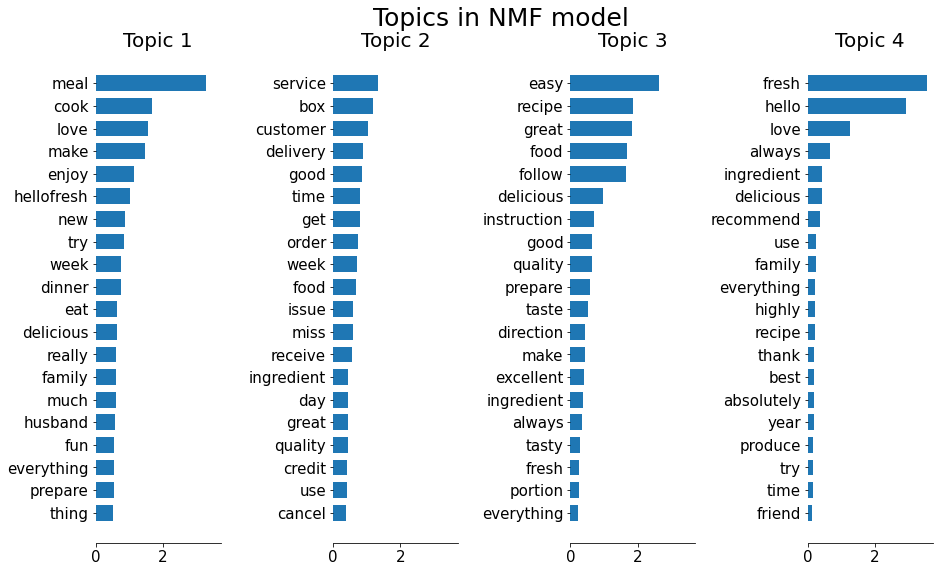

In [44]:
topic_word_plot()